In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import sklearn
import warnings
warnings.filterwarnings('ignore')
import sys

train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

훈련데이터는 총 120만개정도이고 , 테스트 데이터는 5400여개가 존재한다.

각 데이터의 정보를 간략하게 살펴보자.

훈련데이터와 테스트데이터의 레이블을 살펴보면 훈련데이터에만 transaction_real_price가 있는것을 확인할 수 있다. 이는 결국 훈련 데이터를 통해 가격을 예측해보기 위한점이다.

 

[Train Column name Description]

transaction_id : 아파트 거래에 대한 유니크한 아이디
apartment_id : 아파트 아이디
city : 도시
dong : 동
jibun : 지번
apt : 아파트단지 이름
addr_kr : 주소
exclusive_use_area : 전용면적
year_of_completion : 설립일자
transaction_year_month : 거래년월
transaction_date : 거래날짜
floor : 층
transaction_real_price : 실거래가 (target variable)

In [4]:
train_null=train_data.drop('transaction_real_price',axis=1).isnull().sum()/len(train_data)*100
test_null=test_data.isnull().sum()/len(test_data)*100
pd.DataFrame({'train_null_count': train_null,'test_null_count':test_null})

,train_null_count,test_null_count
transaction_id,0.0,0.0
apartment_id,0.0,0.0
city,0.0,0.0
dong,0.0,0.0
jibun,0.0,0.0
apt,0.0,0.0
addr_kr,0.0,0.0
exclusive_use_area,0.0,0.0
year_of_completion,0.0,0.0
transaction_year_month,0.0,0.0


딱히, 결측치는 존재하지 않는다.

 

간단하게 훈련 데이터를 살펴보자.

탐색적 데이터 분석 및 처리
훈련데이터 ['transaction_real_price']레이블의 통계적 요약을 살펴보면 다음과 같다.

평균 38827 Min: 100 MAX: 820000 표준편차:31048

 

이를 그래프로 막대그래프와 왜도 첨도를 통해 그래프를 살펴보자. 

왜도(Skewness): 왼쪽으로 치우쳐져 있을수록 값이 크다.

첨도(Kurtosis): 첨도 값이 3에 가까울 경우 정규분포에 근사한다. 첨도 값이 클수록 뾰족하고 값이 작을수록 완만해진다.

이 그래프를 정규화에 근사시키기 위해 log1p 함수를 이용해 로그를씌워 다시 한번확인해보자.

transaction_real_price -> Skewness: -0.094932, Kurtosis: 0.248866


<AxesSubplot:xlabel='transaction_real_price', ylabel='Density'>

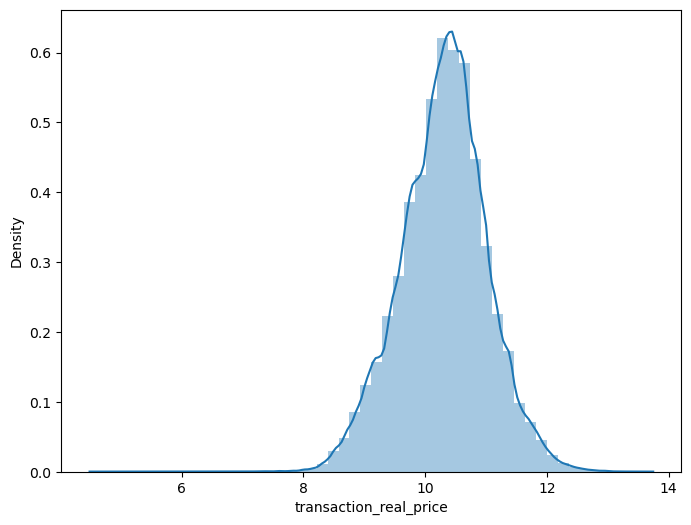

In [5]:
train_data['transaction_real_price'] = np.log1p(train_data['transaction_real_price'])
print("%s -> Skewness: %f, Kurtosis: %f" %  ('transaction_real_price',train_data['transaction_real_price'].skew(),train_data['transaction_real_price'].kurt()))

f,ax=plt.subplots(figsize=(8,6))
sns.distplot(train_data['transaction_real_price'])

칼럼들의 상관관계
각 칼럼들간의 상관관계를 확인해보자. 

<AxesSubplot:>

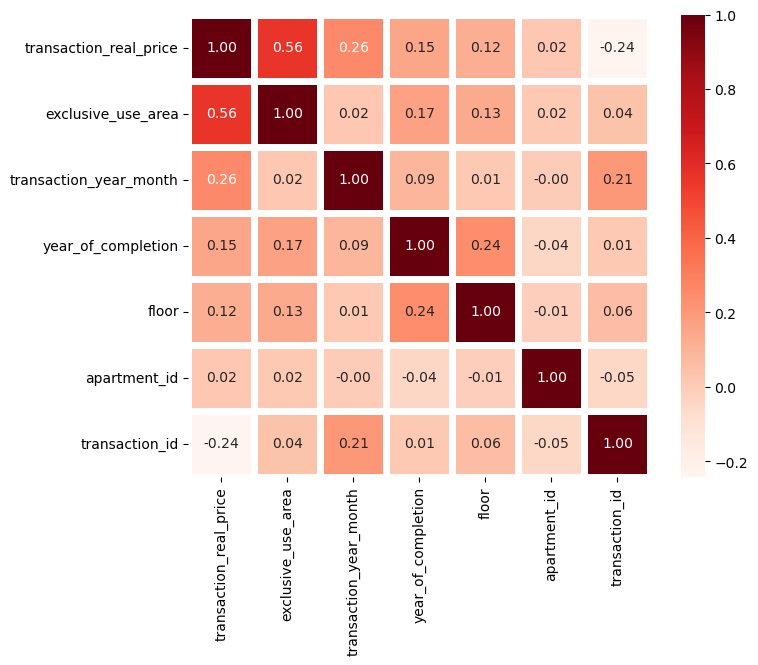

In [6]:
k=train_data.shape[1]
corrmat=train_data.corr()
cols=corrmat.nlargest(k,'transaction_real_price')['transaction_real_price'].index
cm=np.corrcoef(train_data[cols].values.T)
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(data=cm,annot=True,square=True,fmt='.2f',linewidths=5,cmap='Reds',yticklabels=cols.values,xticklabels=cols.values)

훈련데이터의 'apartment_id' 칼럼의 unique_value의 갯수를 확인해보자.

In [7]:
len(train_data['apartment_id'].unique())

12533

이후 'transaction_id'를 따로 변수로 지정한 후, 본래의 데이터프레임에서는 없애주자.

In [8]:
train_id=train_data['transaction_id']
train=train_data.drop('transaction_id',axis=1)
test_id=test_data['transaction_id']
test=test_data.drop('transaction_id',axis=1)

Floor(층)
가설) 층수가 높아질수록 집값도 높아진다.

 

'floor' 과 'transaction_real_price'의 연관성을 확인하기 위해 산점도표에 케스팅해보자. 

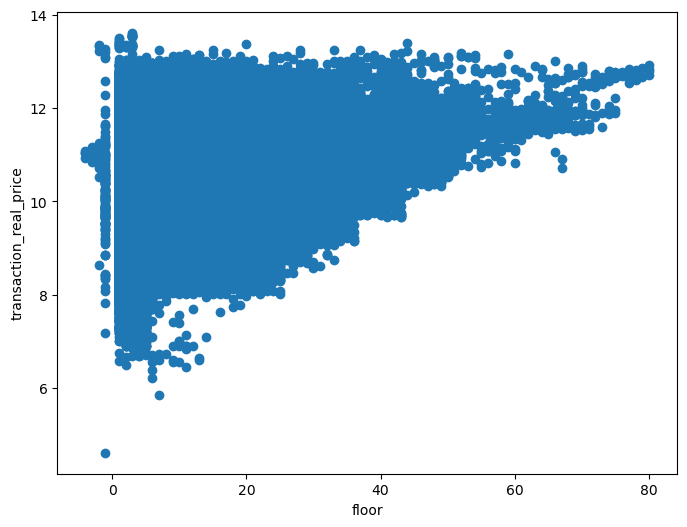

In [9]:
# 집값과 층수의 연관성
f,ax=plt.subplots(figsize=(8,6))
plt.scatter(train['floor'],train['transaction_real_price'])
plt.xlabel('floor')
plt.ylabel('transaction_real_price')
plt.show()

위 그래프를 확인해보면 층수가 높아질수록 집값도 높아진다라는 본인의 생각은 틀린것을 알 수 있다.

 

그렇다면,

floor(층수)칼럼에 대해서 막대그래프를 통한 분포표도 확인해보자.

floor->Skewness: 1.324710, Kurtosis: 3.796603


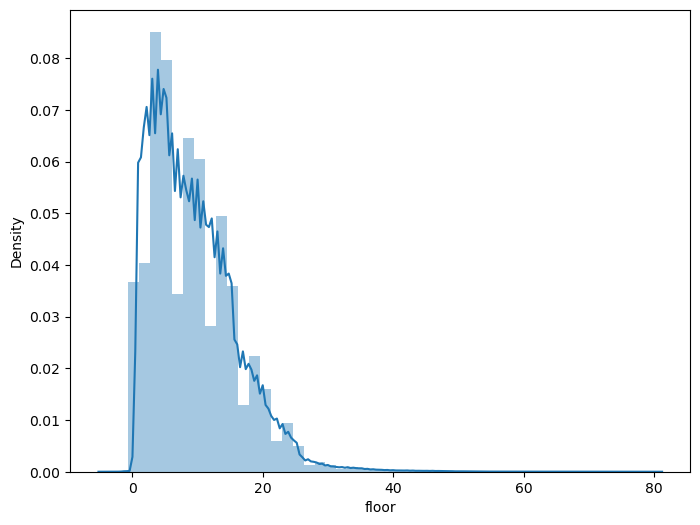

In [10]:
f,ax=plt.subplots(figsize=(8,6))
sns.distplot(train['floor'])
print('%s->Skewness: %f, Kurtosis: %f'% ('floor',train['floor'].skew(),train['floor'].kurt()))

#floor->Skewness: 1.324710, Kurtosis: 3.796603

exclusive_use_area(전용면적)
가설) 전용면적이 넓어지면 넓어질수록 집값은 비싸다

우선 훈련데이터의 'exclusive_use_area'를 간단하게 통계적 요약으로 살펴보자.

In [11]:
train['exclusive_use_area'].describe()

count    1.216553e+06
mean     7.816549e+01
std      2.915113e+01
min      9.260000e+00
25%      5.976000e+01
50%      8.241000e+01
75%      8.497000e+01
max      4.243200e+02
Name: exclusive_use_area, dtype: float64

Mean: 78.1 Min: 9.2 Max: 424.3

이를 산점도표에 케스팅하여 전용면적과 집값의 연관성을 확인해보자.

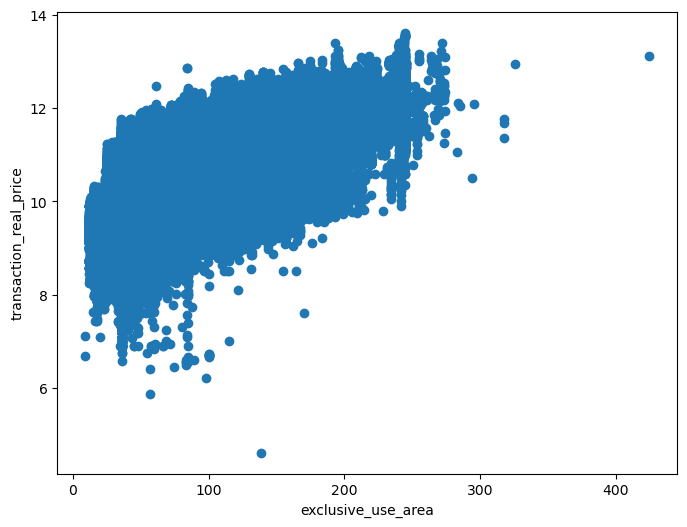

In [12]:
f,ax=plt.subplots(figsize=(8,6))
plt.scatter(train['exclusive_use_area'],train['transaction_real_price'])
plt.xlabel('exclusive_use_area')
plt.ylabel('transaction_real_price')
plt.show()

대략 위 산점도표를 살펴보면, 전용면적이 넓어질수록 집값도 올라가는 경향을 보인다. 그러므로 가설은 맞다고 가정하자.

 

이상치들을 확인해보자.

In [13]:
train[train['exclusive_use_area']>400]

,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
563870,12633,서울특별시,도곡동,193-1,힐데스하임빌라,도곡동 193-1 힐데스하임빌라,424.32,1998,201604,11~20,10,13.118357


In [14]:
train[(train['exclusive_use_area']<150)&(train['transaction_real_price']<200)]

,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.8200,2002,200801,21~31,2,10.532123
1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.1700,1973,200801,1~10,6,9.903538
2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.7400,2007,200801,1~10,6,10.558439
3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.3900,2003,200801,11~20,15,11.678448
5,12536,서울특별시,인의동,48-2,효성쥬얼리시티,인의동 48-2 효성쥬얼리시티,106.8100,2006,200801,1~10,16,11.112463
...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,59.8245,2012,201711,11~20,3,9.998843
1216549,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,7,10.333678
1216550,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,9,10.292179
1216551,9586,부산광역시,정관읍 용수리,1364,정관신도시롯데캐슬,정관읍 용수리 1364 정관신도시롯데캐슬,101.7400,2008,201711,21~30,7,10.192456


크게 이상치라고 판단할수 있는 건 없는것 같다.

이를 한번더 막대 그래프로 살펴보자.

exclusive_use_area->Skewness: 1.227509, Kurtosis= 3.100517


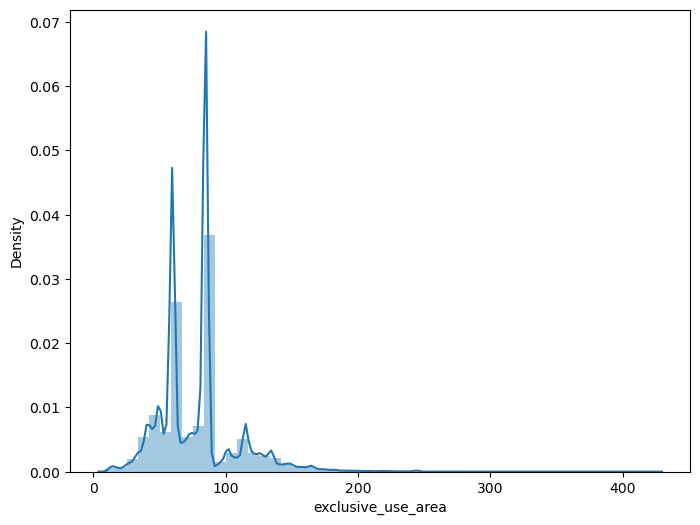

In [15]:
f,ax=plt.subplots(figsize=(8,6))
sns.distplot(train['exclusive_use_area'])
print("%s->Skewness: %f, Kurtosis= %f"% ('exclusive_use_area',train['exclusive_use_area'].skew(),train['exclusive_use_area'].kurt()))

transaction_year_month(거래 년,월)
훈련데이터와 테스트데이터에 있는 년월 칼럼을 따로 뽑아와 새로운 칼럼으로 만들어보자.

In [16]:
train_test_data=[train,test]
for dataset in train_test_data:
    dataset['transaction_year_month']=dataset['transaction_year_month'].astype(str)
    dataset['year']=dataset['transaction_year_month'].str[:4].astype(int)
    dataset['month']=dataset['transaction_year_month'].str[4:6].astype(int)
    dataset['transaction_year_month']=dataset['transaction_year_month'].astype(int)

년도 별로 그래프를 확인해보자.

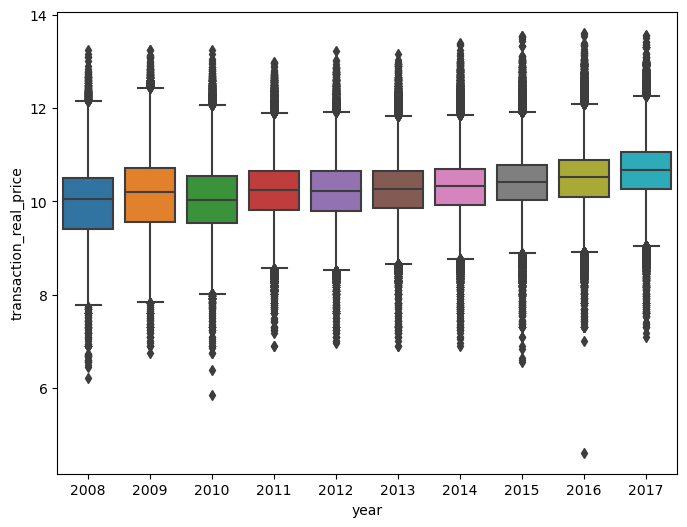

In [17]:
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(train['year'],train['transaction_real_price'])
plt.show()

year_of_completion(설립일자)

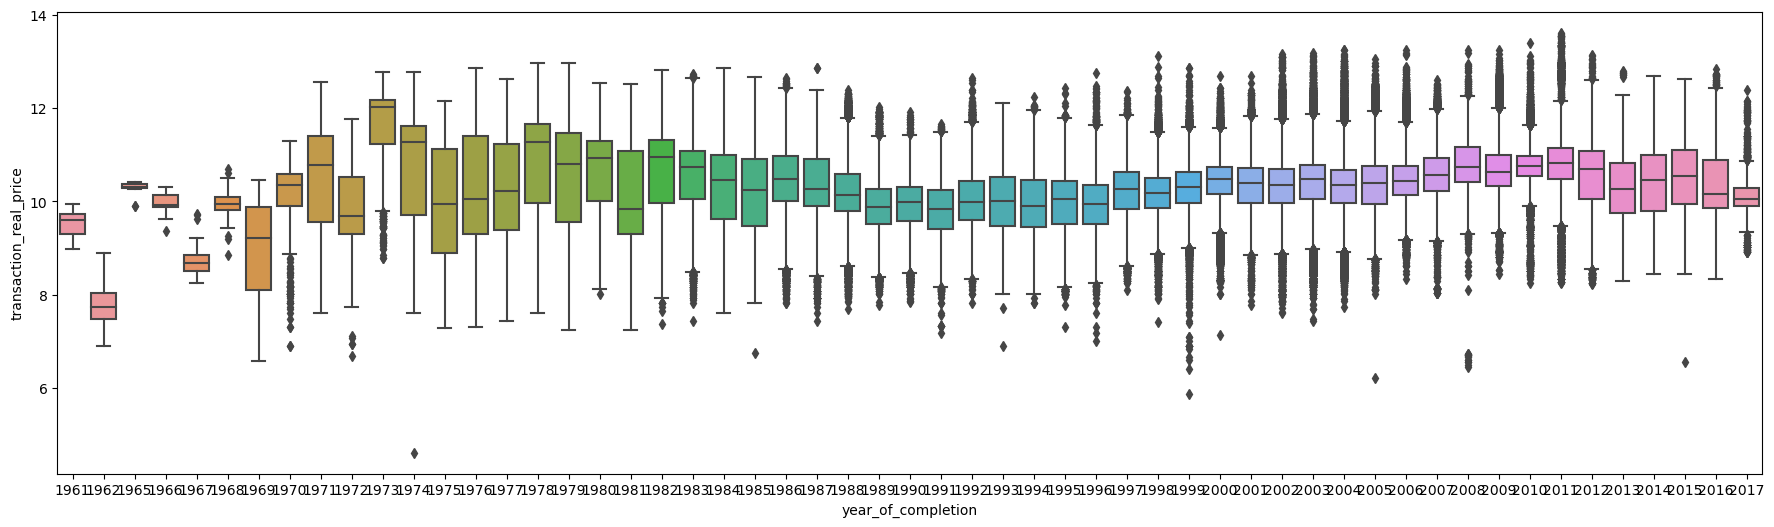

In [18]:
f,ax=plt.subplots(figsize=(22,6))
sns.boxplot(train['year_of_completion'],train['transaction_real_price'])
plt.show()

1974년도에 가장 낮은 값이 있었는데 이는 무엇인지 확인해보자.

In [19]:
train[train['year_of_completion']==1974].sort_values('transaction_real_price',ascending=True)

,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,year,month
722888,6225,부산광역시,범전동,263-5,서면,범전동 263-5 서면,138.25,1974,201606,21~30,-1,4.615121,2016,6
350513,12414,서울특별시,화곡동,354-54,화곡동복지,화곡동 354-54 화곡동복지,53.94,1974,201206,21~30,1,7.601402,2012,6
689192,7162,부산광역시,가야동,385-2,시영,가야동 385-2 시영,39.67,1974,201004,21~30,6,7.696667,2010,4
679153,7162,부산광역시,가야동,385-2,시영,가야동 385-2 시영,39.67,1974,200807,11~20,4,7.824446,2008,7
678316,7162,부산광역시,가야동,385-2,시영,가야동 385-2 시영,39.67,1974,200805,11~20,5,7.863651,2008,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163472,4695,서울특별시,반포동,757,반포 주공1단지,반포동 757 반포 주공1단지,140.33,1974,201706,11~20,2,12.706851,2017,6
1164677,4695,서울특별시,반포동,757,반포 주공1단지,반포동 757 반포 주공1단지,140.33,1974,201709,11~20,3,12.736704,2017,9
1164022,4695,서울특별시,반포동,757,반포 주공1단지,반포동 757 반포 주공1단지,140.33,1974,201707,21~31,5,12.765691,2017,7
1164377,4695,서울특별시,반포동,757,반포 주공1단지,반포동 757 반포 주공1단지,140.33,1974,201708,1~10,3,12.765691,2017,8


# 변수 카테고리화

city(도시)
우선 서울특별시와 부산광역시를 레이블 0,1로 구분시켜 다시 데이터프레임을 구성하자.

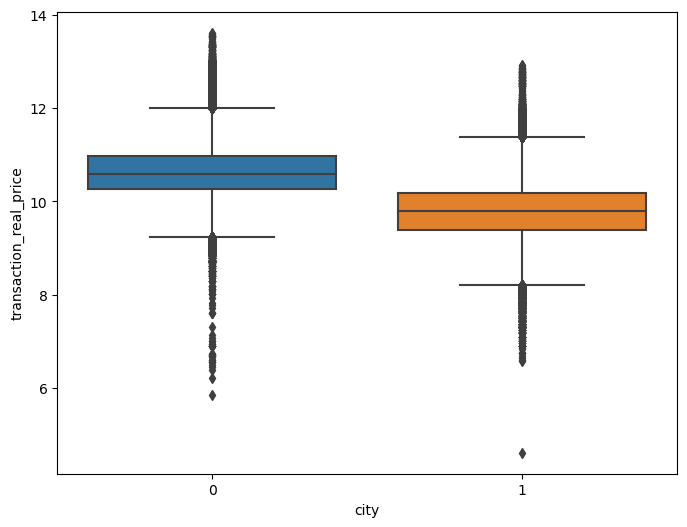

In [20]:
replace_name={'서울특별시':0,'부산광역시':1}
train=train.replace({'city':replace_name})
test=test.replace({'city':replace_name})
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(train['city'],train['transaction_real_price'])
plt.show()

보니 서울이 부산보다 집값이 높은것을 확인할 수 있다. 거래량도 확인해보자

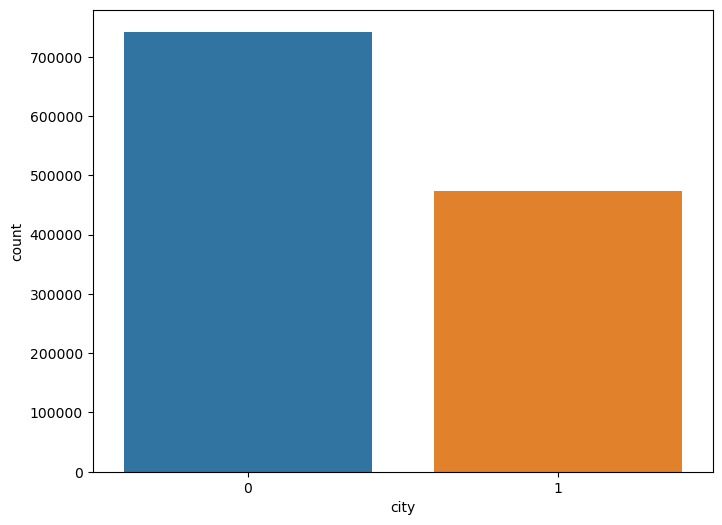

In [21]:
f,ax=plt.subplots(figsize=(8,6))
sns.countplot(train['city'])
plt.show()

이를 통해 집값은 서울이 더 높고, 거래량도 서울이 더 높은것을 확인할 수 있다.

 

addr_kr(주소)
동, 지번, 아파트단지이름을 합친 것을 addr_kr로 하였는데 이는 그냥 삭제해버리자.

In [22]:
train=train.drop('addr_kr',axis=1)
test=test.drop('addr_kr',axis=1)

dong(동)
데이콘 튜토리얼 샘플코드에서는 한강의 유무에 따른 feature를 하나 생성해준다. 그러므로 본인도 만들어놓아본다.

In [23]:
train['hangang']=train['dong'].isin(['성수동1가','삼성동','이촌동','공덕동','서교동','한강로3가','목동']).astype(int)
test['hangang']=train['dong'].isin(['성수동1가','삼성동','이촌동','공덕동','서교동','한강로3가','목동']).astype(int)

In [24]:
len(train['dong'].unique())

473

dong은 그 지역을 그룹핑한 것이다. 그러므로 지역에 따라 가격차이를 확인해 줄 수 있다.

아파트 거래가격의 평균순으로 데이터를 레이블링해보자.

In [25]:
train_dong=train[['transaction_real_price','dong']].groupby('dong').mean().sort_values('transaction_real_price').reset_index()
train_dong.head()

,dong,transaction_real_price
0,신선동3가,8.543619
1,봉래동5가,8.590871
2,장안읍 명례리,8.597728
3,신창동2가,8.601466
4,신선동2가,8.622581


In [26]:
dong_num={}
for i in range(len(train_dong)):
    dong=train_dong['dong'].iloc[i]
    dong_num[dong]=i
dong_num

{'신선동3가': 0,
 '봉래동5가': 1,
 '장안읍 명례리': 2,
 '신창동2가': 3,
 '신선동2가': 4,
 '보수동1가': 5,
 '장충동2가': 6,
 '중앙동4가': 7,
 '부평동2가': 8,
 '수정동': 9,
 '필동1가': 10,
 '아미동2가': 11,
 '동광동5가': 12,
 '기장읍 대변리': 13,
 '초장동': 14,
 '남항동3가': 15,
 '대청동1가': 16,
 '기장읍 서부리': 17,
 '동삼동': 18,
 '반송동': 19,
 '보수동2가': 20,
 '누상동': 21,
 '봉래동3가': 22,
 '대청동4가': 23,
 '서동': 24,
 '일광면 이천리': 25,
 '덕천동': 26,
 '일광면 삼성리': 27,
 '봉래동4가': 28,
 '감만동': 29,
 '영등포동3가': 30,
 '모라동': 31,
 '행촌동': 32,
 '동대신동3가': 33,
 '학장동': 34,
 '구평동': 35,
 '좌천동': 36,
 '금곡동': 37,
 '영주동': 38,
 '장림동': 39,
 '토성동2가': 40,
 '기장읍 청강리': 41,
 '기장읍 대라리': 42,
 '영등포동1가': 43,
 '영등포동2가': 44,
 '미근동': 45,
 '감천동': 46,
 '감전동': 47,
 '전포동': 48,
 '금사동': 49,
 '기장읍 동부리': 50,
 '칠산동': 51,
 '덕포동': 52,
 '초량동': 53,
 '명장동': 54,
 '다대동': 55,
 '서대신동1가': 56,
 '오장동': 57,
 '기장읍 교리': 58,
 '대창동1가': 59,
 '영등포동4가': 60,
 '회동동': 61,
 '신평동': 62,
 '범천동': 63,
 '우암동': 64,
 '구포동': 65,
 '괴정동': 66,
 '당감동': 67,
 '안암동4가': 68,
 '토성동5가': 69,
 '개금동': 70,
 '남산동': 71,
 '당리동': 72,
 '당산동6가': 73,
 '주례동': 74,
 '통인동': 75,
 '청

In [27]:
train=train.replace({'dong': dong_num})
test=test.replace({'dong':dong_num})
train.head()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,year,month,hangang
0,7622,0,351,6-13,신현(101동),84.82,2002,200801,21~31,2,10.532123,2008,1,0
1,5399,0,414,142,사직파크맨션,99.17,1973,200801,1~10,6,9.903538,2008,1,0
2,3578,0,414,174-1,두레엘리시안,84.74,2007,200801,1~10,6,10.558439,2008,1,0
3,10957,0,462,95,파크팰리스,146.39,2003,200801,11~20,15,11.678448,2008,1,0
4,10639,0,462,110-15,킹스매너,194.43,2004,200801,21~31,3,11.695255,2008,1,0


Jibun(지번)
지번의 unique_value를 확인해보자.

In [28]:
len(train['jibun'].unique())

8961

In [29]:
train_jibun=train[['transaction_real_price','jibun']].groupby('jibun').mean().sort_values('transaction_real_price').reset_index()
train_jibun.head()

,jibun,transaction_real_price
0,산3-148,7.225286
1,737-1,7.494417
2,741-1,7.498174
3,1181-4,7.585491
4,11-174,7.601402


apt(아파트)
아파트의 unique_value를 확인해보자

In [30]:
len(train['apt'].unique())

10440

In [31]:
train_apt=train[['transaction_real_price','apt']].groupby('apt').mean().sort_values('transaction_real_price').reset_index()
train_apt.head()

,apt,transaction_real_price
0,좌천시민(737-1),7.494417
1,좌천시민(741-1),7.498174
2,수정(1181-4),7.585491
3,수정(1175-1),7.626830
4,수정(1186-1),7.685623


확인해보니 지번과 아파트 데이터는 unique_value가 너무 많다.. 따로 레이블링은 하지말자..

 

transaction_date(거래 기간)
위 데이터는 처음 거래시작한 day와 거래가 끝난 day의 차이를 칼럼으로 변경시켜주자.

In [32]:
train['day_diff']=train['transaction_date'].str.extract('(~\d+)')[0].str[1:].astype(int)-train['transaction_date'].str.extract('(\d+~)')[0].str[:-1].astype(int)
test['day_diff']=test['transaction_date'].str.extract('(~\d+)')[0].str[1:].astype(int)-test['transaction_date'].str.extract('(\d+~)')[0].str[:-1].astype(int)

In [33]:
len(train['transaction_date'].unique())

6

거래기간은 unique_value가 6개이므로 이는 레이블링 처리를 해주자.

In [34]:
train_date=train[['transaction_real_price','transaction_date']].groupby('transaction_date').mean().sort_values('transaction_real_price').reset_index()
train_date.head()

,transaction_date,transaction_real_price
0,21~29,10.176453
1,21~28,10.286294
2,1~10,10.293390
3,11~20,10.306731
4,21~31,10.318796


In [35]:
date_num={}
for i in range(len(train_date)):
    date=train_date['transaction_date'].iloc[i]
    date_num[date]=i
date_num

#{'21~29': 0, '21~28': 1, '1~10': 2, '11~20': 3, '21~31': 4, '21~30': 5}

{'21~29': 0, '21~28': 1, '1~10': 2, '11~20': 3, '21~31': 4, '21~30': 5}

In [36]:
train=train.replace({'transaction_date':date_num})
test=test.replace({'transaction_date':date_num})
train.head()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,year,month,hangang,day_diff
0,7622,0,351,6-13,신현(101동),84.82,2002,200801,4,2,10.532123,2008,1,0,10
1,5399,0,414,142,사직파크맨션,99.17,1973,200801,2,6,9.903538,2008,1,0,9
2,3578,0,414,174-1,두레엘리시안,84.74,2007,200801,2,6,10.558439,2008,1,0,9
3,10957,0,462,95,파크팰리스,146.39,2003,200801,3,15,11.678448,2008,1,0,9
4,10639,0,462,110-15,킹스매너,194.43,2004,200801,4,3,11.695255,2008,1,0,10


# 전처리
floor 같은 경우 음수값이 존재하기 때문에 log를 취하기 전에 각 값에 +5를 해주어 모든 값을 양수로 만들어주자.

floor->Skewness: 0.089636, Kurtosis: -0.640885


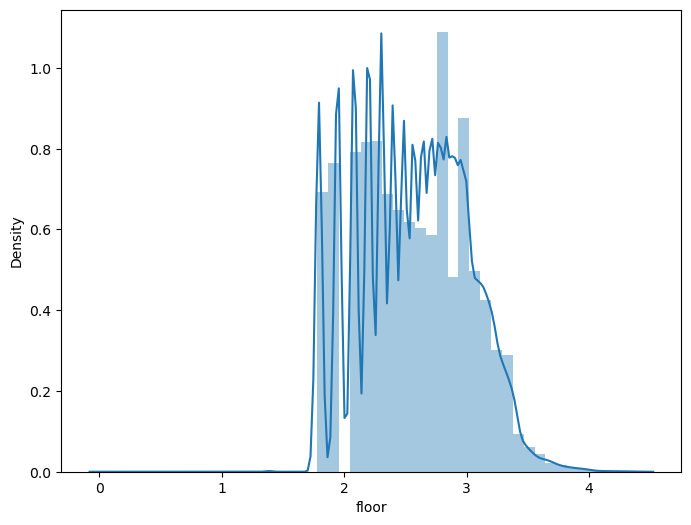

In [37]:
train['floor']=np.log(train['floor']+5)
test['floor']=np.log(test['floor']+5)
f,ax=plt.subplots(figsize=(8,6))
sns.distplot(train['floor'])
print("%s->Skewness: %f, Kurtosis: %f"%('floor',train['floor'].skew(),train['floor'].kurt()))

이제 아파트와 지번 그리고 거래년월을 없애버리자.

In [38]:
drop_columns=['apt','jibun','transaction_year_month']

train=train.drop(drop_columns,axis=1)
test=test.drop(drop_columns,axis=1)
train.head()

,apartment_id,city,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,year,month,hangang,day_diff
0,7622,0,351,84.82,2002,4,1.945910,10.532123,2008,1,0,10
1,5399,0,414,99.17,1973,2,2.397895,9.903538,2008,1,0,9
2,3578,0,414,84.74,2007,2,2.397895,10.558439,2008,1,0,9
3,10957,0,462,146.39,2003,3,2.995732,11.678448,2008,1,0,9
4,10639,0,462,194.43,2004,4,2.079442,11.695255,2008,1,0,10


# Feature Engineering

In [39]:
train_test_data=[train,test]

for dataset in train_test_data:
    dataset['age']=dataset['year']-dataset['year_of_completion']
    dataset['is_rebuild']=(dataset['age']>=30).astype(int)
    

거래하는 기간까지의 아파트 나이를 특징으로 생성해주고, 샘플코드에 있는 아파트의 재건축 유무를 판단하는 특징을 만들어준다.

## 왜도skew() :
 - Skewness를 측정한 값 기준으로 -2~+2는 치우침이 없는 데이터
 - Skewed 데이터를 변환하는 이유는 꼬리에 있는 값을 모델에 제대로 학습시키기 위함이다.
 - -2 미만은 Negative Skew, +2 초과는 Positive Skew
 - Positive Skewness는 오른쪽에 꼬리를 가진(왼쪽에 데이터가 많은)형태이고, Negative Skewness는 왼쪽에 꼬리를 가진(오른쪽에 데이터가 많은) 형태

## 첨도kurt():
- 확률분포의 뾰족한 정도. 표준정규분포와 비교하여 얼마나 뽀족한가 측정 지표
- kurt = 0 : 표준정규분포정도
- kurt < 0 : 표준정규분포보다 둥글다
- kurt > 0 : 표준정규분포보다 뾰족

In [40]:
train_columns=[]
for column in train.columns[:]:
    if train[column].skew()>=1: # 오른쪽 꼬리로 늘어진 그래프인가?
        print('%s -> Skewness: %f, Kurtosis: %f'%(column,train[column].skew(),train[column].kurt()))
        train_columns.append(column)
    elif train[column].kurt()>=3: # 아닐 경우 표준정규분포와 비교해서 얼마나 뾰족한가?
        print('%s -->Skewness: %f, Kurtosis: %f'%(column,train[column].skew(),train[column].kurt()))
        train_columns.append(column)
train_columns

exclusive_use_area -> Skewness: 1.227509, Kurtosis: 3.100517
hangang -> Skewness: 6.358349, Kurtosis: 38.428662
day_diff -->Skewness: -0.589751, Kurtosis: 4.573129
is_rebuild -> Skewness: 3.324832, Kurtosis: 9.054522


['exclusive_use_area', 'hangang', 'day_diff', 'is_rebuild']

정규분포 근사화를 위해 첨도와 왜도를 조정해준다.

In [41]:
for column in train_columns :
    train[column] = np.log1p(train[column])
    test[column] = np.log1p(test[column])
    print("%s -> Skewness: %f, Kurtosis: %f" %  (column,train[column].skew(), 
                                                 train[column].kurt()))
                                                 

exclusive_use_area -> Skewness: -0.438156, Kurtosis: 1.744119
hangang -> Skewness: 6.358349, Kurtosis: 38.428662
day_diff -> Skewness: -1.128137, Kurtosis: 6.788569
is_rebuild -> Skewness: 3.324832, Kurtosis: 9.054522


In [45]:
train

,apartment_id,city,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,year,month,hangang,day_diff,age,is_rebuild
0,7622,0,351,4.452252,2002,4,1.945910,10.532123,2008,1,0.0,2.397895,6,0.000000
1,5399,0,414,4.606869,1973,2,2.397895,9.903538,2008,1,0.0,2.302585,35,0.693147
2,3578,0,414,4.451319,2007,2,2.397895,10.558439,2008,1,0.0,2.302585,1,0.000000
3,10957,0,462,4.993082,2003,3,2.995732,11.678448,2008,1,0.0,2.302585,5,0.000000
4,10639,0,462,5.275202,2004,4,2.079442,11.695255,2008,1,0.0,2.397895,4,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,9578,1,184,4.107993,2012,3,2.079442,9.998843,2017,11,0.0,2.302585,5,0.000000
1216549,9578,1,184,4.454258,2012,5,2.484907,10.333678,2017,11,0.0,2.302585,5,0.000000
1216550,9578,1,184,4.454258,2012,5,2.639057,10.292179,2017,11,0.0,2.302585,5,0.000000
1216551,9586,1,184,4.632202,2008,5,2.484907,10.192456,2017,11,0.0,2.302585,9,0.000000


이제 상관관계를 다시 확인해보자.

<AxesSubplot:>

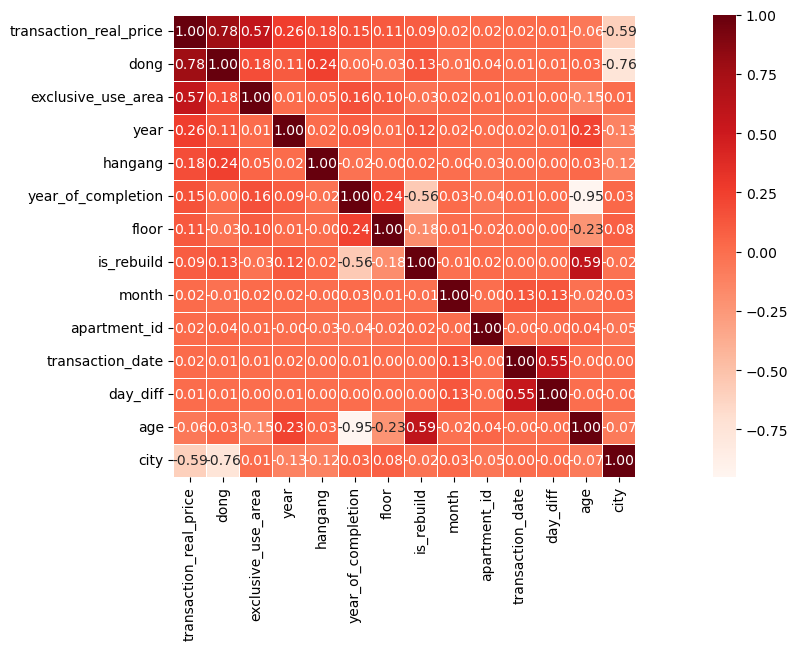

In [41]:
#상관관계 확인
k=train.shape[1] #히트맵 변수 갯수
corrmat = train.corr() #변수간의 상관관계
cols = corrmat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

# 모델링

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 14 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   apartment_id            1216553 non-null  int64  
 1   city                    1216553 non-null  int64  
 2   dong                    1216553 non-null  int64  
 3   exclusive_use_area      1216553 non-null  float64
 4   year_of_completion      1216553 non-null  int64  
 5   transaction_date        1216553 non-null  int64  
 6   floor                   1216553 non-null  float64
 7   transaction_real_price  1216553 non-null  float64
 8   year                    1216553 non-null  int32  
 9   month                   1216553 non-null  int32  
 10  hangang                 1216553 non-null  float64
 11  day_diff                1216553 non-null  float64
 12  age                     1216553 non-null  int64  
 13  is_rebuild              1216553 non-null  float64
dtypes:

In [67]:
my_data = pd.read_csv("./my_data.csv")
my_data

,apartment_id,city,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,year,month,hangang,day_diff,age,is_rebuild
0,1,0,432,79.97,1987,2,2.0,22.0,2021,1,0.0,9.0,34,1.0


In [69]:
(my_data.iloc[0,3])=np.log1p(77.75)
my_data.iloc[0,4]=1988
my_data.iloc[0,6]=np.log(my_data['floor']+5)
my_data.iloc[0,8]=2018
my_data.iloc[0,9]=8
my_data.iloc[0,10]=0
my_data.iloc[0,11]=np.log1p(30)
my_data.iloc[0,12]=0
my_data

,apartment_id,city,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,year,month,hangang,day_diff,age,is_rebuild
0,1,0,432,4.366278,1988,2,1.938153,2018.0,2018,8,0.0,3.433987,0,1.0


In [70]:
my_data.drop('transaction_real_price', axis=1, inplace=True)
my_data

,apartment_id,city,dong,exclusive_use_area,year_of_completion,transaction_date,floor,year,month,hangang,day_diff,age,is_rebuild
0,1,0,432,4.366278,1988,2,1.938153,2018,8,0.0,3.433987,0,1.0


In [71]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [72]:
train1 = train.copy()
train1.head()

,apartment_id,city,dong,exclusive_use_area,year_of_completion,transaction_date,floor,year,month,hangang,day_diff,age,is_rebuild
0,7622,0,351,4.452252,2002,4,1.945910,2008,1,0.0,2.397895,6,0.000000
1,5399,0,414,4.606869,1973,2,2.397895,2008,1,0.0,2.302585,35,0.693147
2,3578,0,414,4.451319,2007,2,2.397895,2008,1,0.0,2.302585,1,0.000000
3,10957,0,462,4.993082,2003,3,2.995732,2008,1,0.0,2.302585,5,0.000000
4,10639,0,462,5.275202,2004,4,2.079442,2008,1,0.0,2.397895,4,0.000000


In [73]:
target = train['transaction_real_price']
print(target)
del train['transaction_real_price']

KeyError: 'transaction_real_price'

In [58]:
#cross validation score
n_folds = 2

def cv_score(models):
    kfold = KFold(n_splits=n_folds, shuffle=True ,random_state=42).get_n_splits(train.values)
    for m in models:
        cvs = np.mean(cross_val_score(m['model'], train.values, target, cv=kfold))
        rmse = np.mean(np.sqrt(-cross_val_score(m['model'], train.values, np.expm1(target), scoring = "neg_mean_squared_error", cv = kfold)))
        print("Model {} CV score : {:.4f}".format(m['name'], cvs))
        print("RMSE : {:.4f}".format(rmse))

In [74]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state=42))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=42))
gboost = GradientBoostingRegressor(random_state=42)
forest = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)
lightgbm = lgb.LGBMRegressor(random_state=42, num_leaves = 100, min_data_in_leaf = 15, max_depth=6,
                            learning_rate = 0.1, min_child_samples = 30, feature_fraction=0.9, bagging_freq= 1,
                            bagging_fraction = 0.9, bagging_seed = 11, lambda_l1 = 0.1, verbosity = -1 )

models = [{'model': gboost, 'name':'GradientBoosting'}, {'model': xgboost, 'name':'XGBoost'},
          {'model': lightgbm, 'name':'LightGBM'}, {'model' : lasso, 'name' : 'LASSO Regression'}, 
          {'model' : ENet, 'name' : 'Elastic Net Regression'}, {'model' : forest, 'name' : 'RandomForset'}]

In [52]:
start = timeit.default_timer()
cv_score(models)
stop = timeit.default_timer()
print('불러오는데 걸린 시간 : {}초'.format(stop - start))

Model GradientBoosting CV score : 0.5817
RMSE : 15794.9626
Model XGBoost CV score : 0.6321
RMSE : 13208.4387
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignore

In [49]:
train[train['dong']==432]

,apartment_id,city,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,year,month,hangang,day_diff,age,is_rebuild
525034,729,0,432,3.607398,1982,2,2.302585,11.082158,2008,1,0.0,2.302585,26,0.000000
525035,730,0,432,3.601141,1982,2,2.079442,11.127278,2008,1,0.0,2.302585,26,0.000000
525036,732,0,432,4.006969,1983,2,2.484907,11.116187,2008,1,0.0,2.302585,25,0.000000
525037,731,0,432,3.760968,1982,2,2.079442,11.287291,2008,1,0.0,2.302585,26,0.000000
525038,731,0,432,3.607398,1982,2,1.791759,11.079076,2008,1,0.0,2.302585,26,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171083,6612,0,432,3.929077,1992,5,2.197225,11.365596,2017,11,0.0,2.302585,25,0.000000
1171084,729,0,432,3.773910,1982,5,2.197225,11.763692,2017,11,0.0,2.302585,35,0.693147
1171085,733,0,432,3.990095,1983,5,2.708050,11.652696,2017,11,0.0,2.302585,34,0.693147
1171086,729,0,432,4.136286,1983,5,1.791759,12.078245,2017,11,0.0,2.302585,34,0.693147


In [75]:
my_data

,apartment_id,city,dong,exclusive_use_area,year_of_completion,transaction_date,floor,year,month,hangang,day_diff,age,is_rebuild
0,1,0,432,4.366278,1988,2,1.938153,2018,8,0.0,3.433987,0,1.0


In [83]:
#여러개의 모델로 만들어진 predict 데이터들의 평균을 구한다.

models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},
         {'model':forest, 'name' : 'RandomForest'}]

def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([m['model'].predict(sub_x.values) for m in models])
    return predictions

In [84]:
print(models[0]['model'].predict(my_data))
print(models[1]['model'].predict(my_data))
print(models[2]['model'].predict(my_data))


[11.65623]
[11.51123891]
[11.71091248]


In [84]:
y_test_pred = AveragingBlending(models, train, target, my_data)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [85]:
predictions = (y_test_pred[:, 0]*0.05 + y_test_pred[:, 1]*0.1 + y_test_pred[:, 2]*0.85)
predictions

array([11.55926523])

In [82]:
y_test_pred

array([11.55860559])

In [63]:
np.expm1(predictions)

array([68896.98280127])

In [56]:
sub = pd.read_csv('./data/21265_transaction_price_data/submission.csv')
sub['transaction_real_price'] = np.expm1(predictions)
sub.to_csv('./data/21265_transaction_price_data/submission.csv', index=False)

In [57]:
pd.read_csv('./data/21265_transaction_price_data/submission.csv')

,transaction_id,transaction_real_price
0,1145756,29151.117841
1,1198704,11840.383727
2,1222384,13056.156989
3,1179897,105425.801413
4,1223091,47557.377292
...,...,...
5458,1174640,62393.661098
5459,1175575,198377.570087
5460,1157024,58059.375762
5461,1136863,41904.942913


In [61]:
train_data[train_data["transaction_id"]== 1145756]

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
